<a href="https://colab.research.google.com/github/TusharV-13/Facial-Emotion-Threshold-based-data-dispatcher/blob/main/WannaCry_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras import regularizers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
import numpy as np
import tensorflow as tf
import sys
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,roc_curve, recall_score, classification_report, f1_score,precision_recall_fscore_support)

In [8]:
# Retrieve and prepare data
wannacry_data = pd.read_csv("https://raw.githubusercontent.com/TusharV-13/Ransomeware_Detection_using_autoencoder-WannaCry-Case-/main/Dataset/wannacry.csv")
benign_data = pd.read_csv("https://raw.githubusercontent.com/TusharV-13/Ransomeware_Detection_using_autoencoder-WannaCry-Case-/main/Dataset/malacious_data.csv").sample(frac = 1)
malware_data = pd.read_csv("https://raw.githubusercontent.com/TusharV-13/Ransomeware_Detection_using_autoencoder-WannaCry-Case-/main/Dataset/malware_data.csv").sample(frac = 1)
malware_train, malware_test = train_test_split(malware_data, test_size = 0.08)

In [9]:
# Autoencoder design
input_dim = malware_train.shape[1]
input_layer = Input(shape=(input_dim, ))
nodes_number = 17
while (nodes_number>=3):
    if nodes_number == 17:
        layer = Dense(nodes_number, activation='tanh')(input_layer)
    else:
        layer = Dense(nodes_number, activation='tanh')(layer)
    nodes_number=nodes_number-2
nodes_number=5
while(nodes_number<=17):
    layer = Dense(nodes_number, activation='tanh')(layer)
    nodes_number=nodes_number+2
output_layer = Dense(input_dim, activation='tanh')(layer)
autoencoder = Model(inputs=input_layer, outputs=output_layer)

nb_epoch = 20
batch_size = 18
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="autoencoder.h5", verbose=0, save_best_only=True)

In [10]:
history = autoencoder.fit(malware_train, malware_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True, validation_data=(malware_test, malware_test), verbose=1, callbacks=[checkpointer]).history
autoencoder = load_model('autoencoder.h5')

predictions_malware = autoencoder.predict(malware_test)
mse_malware = np.mean(np.power(malware_test - predictions_malware, 2), axis=1)

predictions_benign_data = autoencoder.predict(benign_data)
mse_benign = np.mean(np.power(benign_data - predictions_benign_data, 2), axis=1)

predictions_wannacry_data = autoencoder.predict(wannacry_data)
mse_wannacry_data = np.mean(np.power(wannacry_data - predictions_wannacry_data, 2), axis=1)

threshold = np.average(mse_malware)

Epoch 1/20
310/310 [==============================] - 3s 7ms/step - loss: 11800588.0000 - accuracy: 0.4163 - val_loss: 8145790.0000 - val_accuracy: 0.4371
Epoch 2/20
310/310 [==============================] - 2s 6ms/step - loss: 11800457.0000 - accuracy: 0.4204 - val_loss: 8145784.5000 - val_accuracy: 0.4371
Epoch 3/20
310/310 [==============================] - 2s 6ms/step - loss: 11800449.0000 - accuracy: 0.5339 - val_loss: 8145783.5000 - val_accuracy: 0.5402
Epoch 4/20
310/310 [==============================] - 2s 6ms/step - loss: 11800447.0000 - accuracy: 0.5363 - val_loss: 8145782.0000 - val_accuracy: 0.5402
Epoch 5/20
310/310 [==============================] - 2s 6ms/step - loss: 11800454.0000 - accuracy: 0.5363 - val_loss: 8145782.0000 - val_accuracy: 0.5402
Epoch 6/20
310/310 [==============================] - 2s 6ms/step - loss: 11800450.0000 - accuracy: 0.5363 - val_loss: 8145782.0000 - val_accuracy: 0.5402
Epoch 7/20
310/310 [==============================] - 2s 6ms/step - lo

In [11]:
acc=0
rec = 0

# fine tune the threshold if needed
while rec<.6 or acc<.6 :
    threshold = threshold - 0.0001
    print(threshold)
    TP,FP,TN,FN=0,0,0,0
    for e in mse_malware:
        if e<threshold:
            TP+=1
        else:
            FN+=1
    for e in mse_benign:
        if e>=threshold:
            TN+=1
        else:
            FP+=1
    try:
        acc = 1.*(TP+TN)/(TP+TN+FP+FN)
        rec = 1.*(TP)/(TP+FN)
        prec = 1. * TP / (TP + FP)
        print (f"TP:{TP}\nFP:{FP}\nTN:{TN}\nFN:{FN}")
        print (f"Accuracy: {acc}\nRecall: {rec}\nPrecision: {prec}")
    except:
        pass

8145782.058864454
TP:446
FP:222
TN:150
FN:39
Accuracy: 0.6954492415402567
Recall: 0.9195876288659793
Precision: 0.6676646706586826



WannaCry prediction certitude: 1.928816624742134


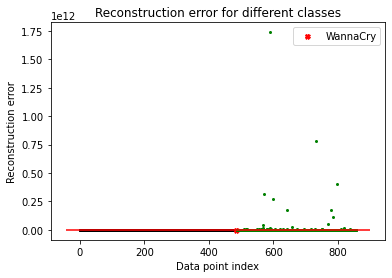

In [12]:
#Generating plot to assess autoencoder model
prediction_certitude = 0
fig, ax = plt.subplots()
i = 0
for e in mse_malware:
    ax.plot(i, e, marker = 'o', ms = 2, linestyle='', color='black')
    i += 1
for e in mse_wannacry_data:
    ax.plot(i, e, marker = 'X', ms = 5, linestyle = '', color='red', label = 'WannaCry')
    prediction_certitude = (2. * threshold - e) / threshold
    i += 1
for e in mse_benign:
    ax.plot(i, e, marker = 'o', ms = 2, linestyle = '', color = 'green')
    i += 1

ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="red", zorder=100)#, label='Threshold')

print (f"\nWannaCry prediction certitude: {prediction_certitude}")

ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();